In [211]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.compose import ColumnTransformer

In [212]:
#we import the first csv. It contains the time stamps for users logging on the product
df_login = pd.read_csv('/Users/irislu/Downloads/relax_challenge/takehome_user_engagement.csv',parse_dates=["time_stamp"])
df_login

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
...,...,...,...
207912,2013-09-06 06:14:15,11996,1
207913,2013-01-15 18:28:37,11997,1
207914,2014-04-27 12:45:16,11998,1
207915,2012-06-02 11:55:59,11999,1


In [213]:
#the second csv contains information of each registered user. It is the source of the feature design later
df_info = pd.read_csv('/Users/irislu/Downloads/relax_challenge/takehome_users.csv',encoding = "ISO-8859-1",
                      parse_dates=['creation_time'])
                   
df_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 937.6+ KB


In [214]:
#make each column the right data type
df_info.opted_in_to_mailing_list = df_info.opted_in_to_mailing_list.astype('bool')
df_info.enabled_for_marketing_drip = df_info.enabled_for_marketing_drip.astype('bool')


df_info.creation_source = df_info.creation_source.astype('category')

In [215]:
#we can see there are Nans in the columns of last_session_creation_time and invited_by_user_id. 
#we transform last_session_creation_time to datetime and find how we cam impute the last_session_creation_time
#we try to see if majority of the users have the same creation_time and last_session_creation_time.
#only 3027 out of 8823 do so we have to figure something else out
df_info['last_session_creation_time'] = pd.to_datetime( df_info['last_session_creation_time'],unit='s')
valid_count = df_info['last_session_creation_time'] == df_info['creation_time']
np.sum(valid_count )


3027

In [216]:
# we know if there is no invited_by_user_id, it means the customer signed up without introduced by current user. 
#We will fill in 0 thereso when we do onehotencoder, the model can tell them apart.
df_info.invited_by_user_id.fillna(0,inplace=True)

#for last_session_creation_time, we will extract the year, month and day info to make new features
df_info['last_session_year'] = df_info.last_session_creation_time.dt.year
df_info['last_session_month'] = df_info.last_session_creation_time.dt.month
df_info['last_session_day'] = df_info.last_session_creation_time.dt.day

# we fill null values with 0 for the model to tell the difference
df_info.last_session_day.fillna(0, inplace=True)
df_info.last_session_month.fillna(0, inplace=True)
df_info.last_session_year.fillna(0, inplace=True)


df_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 13 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null category
last_session_creation_time    8823 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null bool
enabled_for_marketing_drip    12000 non-null bool
org_id                        12000 non-null int64
invited_by_user_id            12000 non-null float64
last_session_year             12000 non-null float64
last_session_month            12000 non-null float64
last_session_day              12000 non-null float64
dtypes: bool(2), category(1), datetime64[ns](2), float64(4), int64(2), object(2)
memory usage: 973.0+ KB


In [217]:
#now we can start feature design. From creation_time, we can extract which year and which month the user sined up. This
#information may affect whether the user is adopted

df_info['creation_year'] = df_info['creation_time'].dt.year
df_info['creation_month'] = df_info['creation_time'].dt.month
df_info['creation_day'] = df_info['creation_time'].dt.day

df_info

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,last_session_year,last_session_month,last_session_day,creation_year,creation_month,creation_day
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,True,False,11,10803.0,2014.0,4.0,22.0,2014,4,22
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,False,False,1,316.0,2014.0,3.0,31.0,2013,11,15
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,False,False,94,1525.0,2013.0,3.0,19.0,2013,3,19
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,False,False,1,5151.0,2013.0,5.0,22.0,2013,5,21
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,False,False,193,5240.0,2013.0,1.0,22.0,2013,1,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,2013-09-06 06:14:15,False,False,89,8263.0,2013.0,9.0,6.0,2013,9,6
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,2013-01-15 18:28:37,False,False,200,0.0,2013.0,1.0,15.0,2013,1,10
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,2014-04-27 12:45:16,True,True,83,8074.0,2014.0,4.0,27.0,2014,4,27
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,2012-06-02 11:55:59,False,False,6,0.0,2012.0,6.0,2.0,2012,5,31


In [218]:
# we have to think about the categorical features here. The org_ids has 417 values. We can see here the top 20 only 
#takes up 1/6 of the total records so we will keep all the org_ids in the one hot encoding 
print(df_info.groupby('org_id').org_id.count())
print(Counter(df_info.org_id).most_common(20))

org_id
0      319
1      233
2      201
3      168
4      159
      ... 
412     17
413     16
414     20
415     16
416      2
Name: org_id, Length: 417, dtype: int64
[(0, 319), (1, 233), (2, 201), (3, 168), (4, 159), (6, 138), (5, 128), (9, 124), (7, 119), (10, 104), (8, 97), (14, 87), (11, 75), (12, 75), (17, 74), (18, 73), (16, 72), (13, 72), (20, 68), (15, 64)]


In [219]:
# we can see for invited_by_user_id, most people signed up without an invitation and the rest of the current user only 
#have limited influence individually. This means the feature has high cardinality. We will include the top 20 ids
#and mark others as '9999' because the one hot encoder can only take uniformly strings or numbers
print(len(df_info.invited_by_user_id.unique()))
print(Counter(df_info.invited_by_user_id).most_common(20))
top20 = Counter(df_info.invited_by_user_id).most_common(20)
keep_id = []
for ids,number in top20:
    keep_id.append(ids)
    

df_info.invited_by_user_id = [x if x in keep_id else 9999 for x in df_info.invited_by_user_id]
 

2565
[(0.0, 5583), (10741.0, 13), (2527.0, 12), (1525.0, 11), (2308.0, 11), (11770.0, 11), (10481.0, 10), (8068.0, 10), (2354.0, 10), (4302.0, 10), (10628.0, 10), (4612.0, 10), (7012.0, 10), (6370.0, 10), (4803.0, 10), (1175.0, 10), (3721.0, 9), (9434.0, 9), (4551.0, 9), (2922.0, 9)]


In [220]:
#the questions here is to study on users logging in on on three separate days in at least one seven-day period, so we 
#change the time stamps in to the date format
df_login.time_stamp = df_login.time_stamp.dt.date
df_login

,time_stamp,user_id,visited
0,2014-04-22,1,1
1,2013-11-15,2,1
2,2013-11-29,2,1
3,2013-12-09,2,1
4,2013-12-25,2,1
...,...,...,...
207912,2013-09-06,11996,1
207913,2013-01-15,11997,1
207914,2014-04-27,11998,1
207915,2012-06-02,11999,1


In [221]:
# Now we know whether a customer is adopted user is the target so this is a binary classification problem.
#here we include the adopted user into a dictionary:

df_groupby = df_login.groupby('user_id')
adopted_user = defaultdict()
#we group by user_id and we loop through each group
for user, group in df_groupby:
    #we drop the duplicate dates for each user since mutiple logins does not count into the 3 counts in 7 days standard
    group_ = group.drop_duplicates(subset=['time_stamp'])
    # we sort by the time stamps
    group_ = group_.sort_values(by=['time_stamp'])

    #now we start filter them,if the user log in on less than 3 seperate days, it is obvious that this user is 
    #not eligible
    if len(group_) < 3:
        continue
    
    else:
        i = 0
        while i < len(group_)-2:
            #we caculate the 7th day as end date of each time stamp and see the next two stamps will fall in before 
            #the end date
            end_date = group_.time_stamp.iloc[i] + pd.Timedelta('7D')
            if (group_.time_stamp.iloc[i+1] < end_date) & (group_.time_stamp.iloc[i+2] <= end_date):
                # if yes, then we put the user in the dictionary
                adopted_user[user] = 1
                break
            i = i+1
            
                
           
           
    

In [222]:
# we can see 1,656 users are adopted, which is a small fraction of the total 12,000 users so we know this is an 
#unbalanced dataset

len(adopted_user)


1656

In [223]:
# now we get our target ready for the model because only these 1656 users are adoped and the target value for them is 
#1
adopt = pd.DataFrame(list(adopted_user.items()),columns=['user_id','target'])
adopt

,user_id,target
0,2,1
1,10,1
2,20,1
3,33,1
4,42,1
...,...,...
1651,11965,1
1652,11967,1
1653,11969,1
1654,11975,1


In [230]:
# we will merge the target into the df_info and make sure the unadoped user's target value is 0
df = df_info.merge(adopt, how='left', left_on='object_id',right_on='user_id')
df = df.drop(columns=['user_id','last_session_creation_time'])

df.target = df.target.fillna(0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 16 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null category
opted_in_to_mailing_list      12000 non-null bool
enabled_for_marketing_drip    12000 non-null bool
org_id                        12000 non-null int64
invited_by_user_id            12000 non-null float64
last_session_year             12000 non-null float64
last_session_month            12000 non-null float64
last_session_day              12000 non-null float64
creation_year                 12000 non-null int64
creation_month                12000 non-null int64
creation_day                  12000 non-null int64
target                        12000 non-null float64
dtypes: bool(2), category(1), datetime64[ns](1), floa

In [231]:
# we create a pipleine to make sure we scale the numerical features and we will let the categorical features that need
#transforming go through one hot encoder. There are also two columns that are not changed

num_cols = ['creation_year','creation_month','creation_day','last_session_year','last_session_month','last_session_day']
cat_cols = ['creation_source','org_id','invited_by_user_id']
unchanged = ['opted_in_to_mailing_list','enabled_for_marketing_drip']
cat_encoder = OneHotEncoder()
pipeline = ColumnTransformer([('num',StandardScaler(),num_cols),
                              ('cat', cat_encoder,cat_cols),
                              ('unchanged','passthrough',unchanged)])


In [232]:
#we use random forest feature importance method to learn which features matter the most here

X = pipeline.fit_transform(df)
y = df['target']
rf_clf = RandomForestClassifier()
rf_clf.fit(X,y)

importance = rf_clf.feature_importances_


In [233]:
#since we have a lot of features due to one hot encoder, we only pick the top 10 most important features here
cat_encoder.fit(df[['creation_source','org_id','invited_by_user_id']])
feature_name = num_cols + list(cat_encoder.get_feature_names()) + unchanged
top_indices = np.argsort(importance)[-10:]

In [234]:
cat_encoder.get_feature_names()

array(['x0_GUEST_INVITE', 'x0_ORG_INVITE', 'x0_PERSONAL_PROJECTS',
       'x0_SIGNUP', 'x0_SIGNUP_GOOGLE_AUTH', 'x1_0', 'x1_1', 'x1_2',
       'x1_3', 'x1_4', 'x1_5', 'x1_6', 'x1_7', 'x1_8', 'x1_9', 'x1_10',
       'x1_11', 'x1_12', 'x1_13', 'x1_14', 'x1_15', 'x1_16', 'x1_17',
       'x1_18', 'x1_19', 'x1_20', 'x1_21', 'x1_22', 'x1_23', 'x1_24',
       'x1_25', 'x1_26', 'x1_27', 'x1_28', 'x1_29', 'x1_30', 'x1_31',
       'x1_32', 'x1_33', 'x1_34', 'x1_35', 'x1_36', 'x1_37', 'x1_38',
       'x1_39', 'x1_40', 'x1_41', 'x1_42', 'x1_43', 'x1_44', 'x1_45',
       'x1_46', 'x1_47', 'x1_48', 'x1_49', 'x1_50', 'x1_51', 'x1_52',
       'x1_53', 'x1_54', 'x1_55', 'x1_56', 'x1_57', 'x1_58', 'x1_59',
       'x1_60', 'x1_61', 'x1_62', 'x1_63', 'x1_64', 'x1_65', 'x1_66',
       'x1_67', 'x1_68', 'x1_69', 'x1_70', 'x1_71', 'x1_72', 'x1_73',
       'x1_74', 'x1_75', 'x1_76', 'x1_77', 'x1_78', 'x1_79', 'x1_80',
       'x1_81', 'x1_82', 'x1_83', 'x1_84', 'x1_85', 'x1_86', 'x1_87',
       'x1_88', 'x1_89

<BarContainer object of 10 artists>

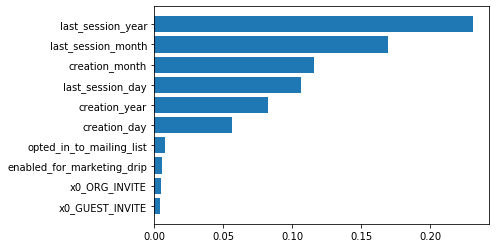

In [235]:
# we can see obviously the last_session_creation_time, creation_month, creation_year
plt.barh([feature_name[i] for i in top_indices], np.sort(importance)[-10:])

# summary

We can see clearly from the chart that the most important features are all around last_session_time and creation time. It is clearly when the user created the account and the time when the user logged in are critical to predict if the customer will be an adoped customer. 

Factors like whether they have opted into receiving marketing emails, whether they are on the regular marketing email drip and how the account was created have smaller impact on the prediction.
